<a href="https://colab.research.google.com/github/THARAKESWAR-P/FirstRepo/blob/master/DL_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Submit the assignment with roll_number as *roll_number*.ipynb file.

# Task-1 : Implement VGG16 on Food101 dataset.
Your first task would be to implement the VGG16 architecture model class and train a classification model on the Food101 dataset using the above architecture. The details of the dataset are given below.  

### 1.1 Import packages
Some packages are imported. However, you would need to import any other package that is required in the implementation that you feel is required. But do keep in mind, your model shouldn't be imported. It has to be implemented using the basic convolution layers.

In [2]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


### 1.2. Dataset
The Food-101 is a challenging data set of 101 food categories with 101,000 images. All images were rescaled to have a maximum side length of 512 pixels. Implementing the below cell will allow you to download the dataset into your colab directory under ```/data/food-101```.
Inside the directory you would find the information about the dataset and also a ReadMe.txt file.

Now, the image size of the dataset is ```(512,512,3)```. However, the model expects the image to be of the size ```(224,224,3)```. Now using the transforms method, write a composed transformation where you implement the resize as well as convert to tensor function. Do some basic preprocessing as well, Normalisation, Standardization etc. \
Hint : use the ``` transform.Compose() ``` method.




In [ ]:
### YOUR CODE STARTS HERE ###
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

### YOUR CODE ENDS HERE ###

In [ ]:
# Setup training data
train_data = datasets.Food101(
    root="data",
    split="train", # get training data
    download=True
    # transform=transform
)

# Setup testing data
test_data = datasets.Food101(
    root="data",
    split="test", # get test data
    download=True,
    transform=transform
)

class ReducedFood101Dataset(Dataset):
    def __init__(self, original_dataset, transform=None, samples_per_class=5):
        """
        Args:
            original_dataset (Dataset): Original PyTorch dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
            samples_per_class (int): Number of samples to take from each class.
        """
        self.original_dataset = original_dataset
        self.transform = transform
        self.samples_per_class = samples_per_class
        self.data = []
        self.classes = original_dataset.classes

        # Reduce the dataset
        self.reduce_dataset()

    def reduce_dataset(self):
        class_counts = {}
        # Count number of samples per class
        for idx in range(len(self.original_dataset)):
            _, label = self.original_dataset[idx]
            if label not in class_counts:
                class_counts[label] = 1
            else:
                class_counts[label] += 1

        # For each class, randomly select 'samples_per_class' images
        for idx in range(len(self.original_dataset)):
            image, label = self.original_dataset[idx]
            if class_counts[label] <= self.samples_per_class:
                self.data.append((image, label))
            else:
                class_counts[label] -= 1
                if random.random() < self.samples_per_class / class_counts[label]:
                    self.data.append((image, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# Instantiate the dataset
train_data = ReducedFood101Dataset(train_data, transform=transform, samples_per_class=5)


For visualization, we randomly select 10 classes of the dataset and plot corresponding images.

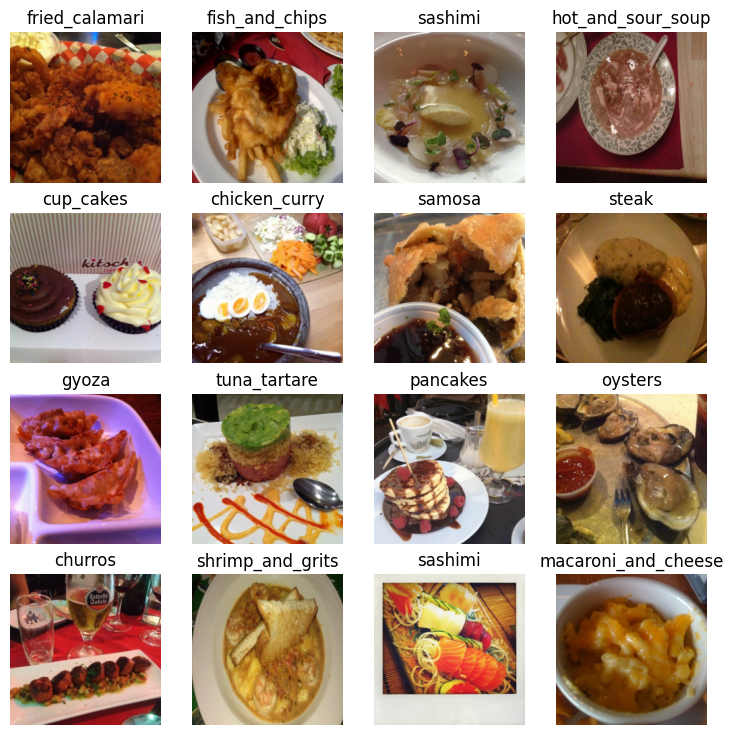

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
class_names = train_data.classes
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False);

### 1.3. Prepare Dataloader
Now, in the cell below implement the DataLoader function for the train and test data. You then have to print the length of the train and test dataloaders.

Length of train dataloader: 95 batches of 32
Length of test dataloader: 790 batches of 32


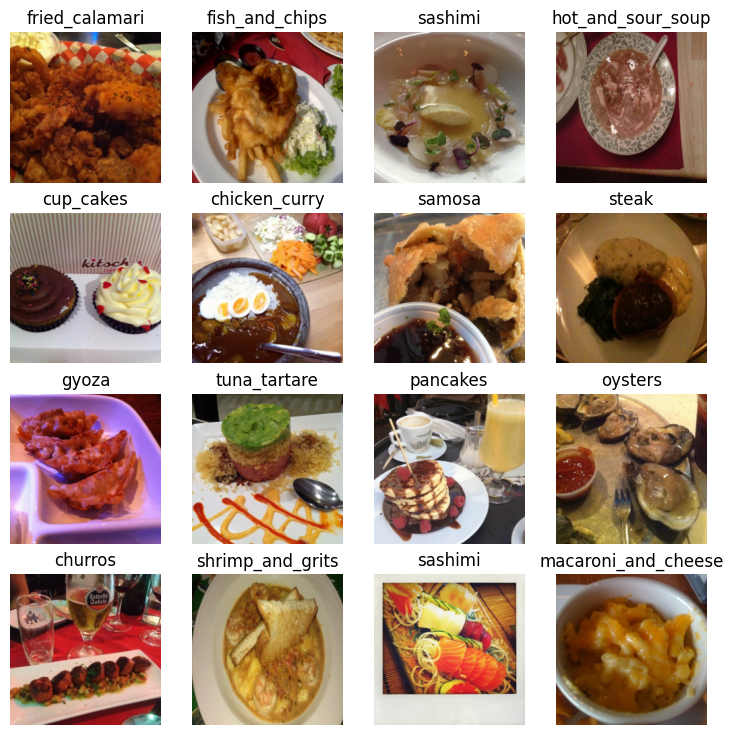

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

### YOUR CODE STARTS HERE ###
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
class_names = train_data.classes
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[label])
    plt.axis(False)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
### YOUR CODE ENDS HERE ###



print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

### 1.4. VGG16 Architecture
Now, create a model class and implement the VGG16 architecture. The architecture layer is as follows :
![Alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*6VP81rFoLWp10FcG)
![Alt text](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*0M8CobXpNwFDCmOQ)

VGG16 takes input tensor size as 224, 244 with 3 RGB channel. It has 13 convolutional layers, 5 Max Pooling layers, and 3 Dense layers which sum up to 21 layers.



Implement the model class in the given cell below. DONOT change the class name as that would be required in the next cell.

In [ ]:

### REPLACE WITH YOUR OWN CODE . DONOT CHANGE THE CLASS NAME ###

class VGG16(nn.Module):
  def __init__(self, num_classes=101):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc6 = nn.Linear(512 * 7 * 7, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)

  def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.pool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.pool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.pool(x)
        x = x.view(-1, 512 * 7 * 7)
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return x

### 1.5. Model Training
Train the above defined model using the following configurations :    
*   #epochs = 5
*   learning rate = 0.05
* loss = cross entropy
* optimizer = Adam\
After training, save the model with the name : ```food101_vgg16_model.pt```



In [ ]:
num_classes = 101
learning_rate = 0.05
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG16(num_classes).to(device)


### YOUR CODE STARTS HERE ###
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), 'food101_vgg16_model.pt')

### YOUR CODE ENDS HERE ###


Epoch [1/5], Loss: 4.974057524690425e+18
Epoch [2/5], Loss: 4.677532095658152
Epoch [3/5], Loss: 4.642635255110891


### 1.6. Evaluate the model
Load the trained model and evaluate on the test data.

In [ ]:
### YOUR CODE STARTS HERE ###
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

### YOUR CODE ENDS HERE ###

# Task-2 : Finetuning VGG16
In this task, you would use the concept of transfer learning to train a pretrained model of VGG16 on the Food101 dataset. You would use the pretrained model of vgg16 from the pytorch library and use a classification head having the number of classes same as given in the dataset(as like above). Use cross entropy loss and SGD optimizer to train on the training data. Report the accuracy measure of the previous model (from scratch) and this finetuned version. Prepare a graph showing the accuracy of the models.

In [1]:
### YOUR CODE STARTS HERE ###

# Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze parameters
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the classifier
num_classes = 101
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.05, momentum=0.9)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Training the fine-tuned model
num_epochs = 5
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluating the model
    vgg16.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracy = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {100 * accuracy:.2f}%")

# Plotting the training and test losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


### YOUR CODE ENDS HERE ###

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 112MB/s] 


NameError: name 'nn' is not defined